# Fine Tune BERT for Multi-Class Classification
* Notebook by Adam Lang
* Date: 6/25/2024

# Overview
* This notebook will go over fine tuning BERT for Multi-Class Classification.
* Specifically we will do the following:
   * 1. Use a BERT base uncased model pre-trained on the Turkish Oscar Corpus: https://huggingface.co/dbmdz/bert-base-turkish-uncased
   * 2. Perform multi-label text classification

In [1]:
## install transformers datasets libraries
!pip install transformers datasets

In [2]:
# imports
import torch
import os
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

In [3]:
# setup device agnostic code
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
#print device
device

'cuda'

## Dataset
* This is a dataset of multiple labels from a Turkish newspaper from Kaggle.
* Kaggle Dataset: https://www.kaggle.com/datasets/savasy/ttc4900

In [4]:
# dataset path
data_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/NLP_deep_learning/BERT_transformers/7allV03.csv'

In [5]:
# upload
df = pd.read_csv(data_path)

# sample the data
df = df.sample(frac=1.0, random_state=42)

# df head
df.head()

,category,text
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...
3539,spor,g saray a git santos van_persie den forma ala...
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...


In [6]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4900 entries, 4657 to 860
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  4900 non-null   object
 1   text      4900 non-null   object
dtypes: object(2)
memory usage: 114.8+ KB


In [7]:
# df dtypes
df.dtypes

category    object
text        object
dtype: object

In [8]:
# null data?
df.isnull().sum()

category    0
text        0
dtype: int64

In [9]:
## value counts of category
df['category'].value_counts()

category
teknoloji     700
spor          700
dunya         700
kultur        700
ekonomi       700
saglik        700
siyaset       700
Name: count, dtype: int64

Summary:
* This appears to be a very balanced dataset with all categories or labels having equal number of text entries.

## Get the labels from the dataset

In [10]:
# label extract unique labels --> to a list
labels = df['category'].unique().tolist()

# Strip any white spaces from the labels via list comprehension
labels = [l.strip() for l in labels]

# print labels for classfication
labels

['teknoloji', 'spor', 'dunya', 'kultur', 'ekonomi', 'saglik', 'siyaset']

In [11]:
# how many labels?
print(len(labels))

7


In [12]:
# print the labels: k is the list index, v is the value
for k,v in enumerate(labels):
  print(v)

teknoloji
spor
dunya
kultur
ekonomi
saglik
siyaset


## Create a dictionary or hash map of labels with an id
* We need these mappings to run a huggingface pipeline.
* We need these as the classification labels to predict the labels.
* The reason for 2 dictionaries:
    * 1. label2id --> this is so we can convert the labels to numeric form for deep learning transformers.
    * 2. id2labels --> we then need to be able to convert the numeric representations back to interpretable results which are the actual text label classification.
* BertForSequenceClassification
  * This is the HuggingFace model we are using.
  * The model requires the data input in this form: https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#bertforsequenceclassification

In [13]:
# set the number of labels we need
NUM_LABELS = len(labels)

# id to label dictionary comprehension
id2label = {id:label for id,label in enumerate(labels)}

# label to id dictionary comprehension
label2id = {label:id for id, label in enumerate(labels)}

In [14]:
# print the labels to id dictionary
label2id

{'teknoloji': 0,
 'spor': 1,
 'dunya': 2,
 'kultur': 3,
 'ekonomi': 4,
 'saglik': 5,
 'siyaset': 6}

In [15]:
## print id to labels
id2label

{0: 'teknoloji',
 1: 'spor',
 2: 'dunya',
 3: 'kultur',
 4: 'ekonomi',
 5: 'saglik',
 6: 'siyaset'}

## Create new column for numerical category representation

In [16]:
## reminder of df
df.head()

,category,text
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...
3539,spor,g saray a git santos van_persie den forma ala...
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...


In [17]:
# can also do this with pd.factorize pandas method: https://pandas.pydata.org/docs/reference/api/pandas.factorize.html
# df['labels'] = pd.factorize(df['category'])[0]

In [18]:
# create new column --> lambda function to strip labels/spaces and apply numeric code
df['labels'] = df['category'].map(lambda x: label2id[x.strip()])

In [19]:
## look at new column
df.head()

,category,text,labels
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...,0
3539,spor,g saray a git santos van_persie den forma ala...,1
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...,2
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...,0
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...,1


## Exploratory Data Analysis
* In multi-label classification NLP tasks it is prudent to explore your data and make sure there are no significant data quality issues including imbalance that may result in biases in the prediction model you build.

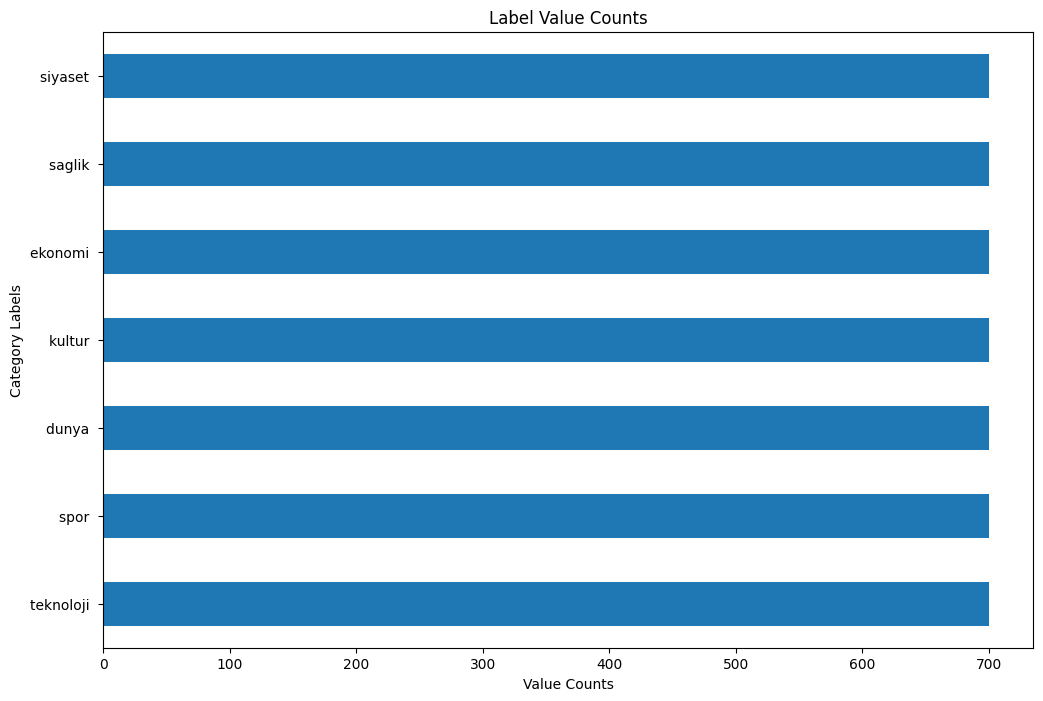

In [20]:
## plotting the category labels
import matplotlib.pyplot as plt
%matplotlib inline

## plotting labels
df['category'].value_counts().plot(kind='barh', figsize=(12,8))
plt.title('Label Value Counts')
plt.xlabel('Value Counts')
plt.ylabel('Category Labels')
plt.show();

This just confirms that all labels have the same number of values of equal distribution with no imbalance noted.

## Tokenizer
* Next we need to instantiate the tokenizer for the bert model we will be using.
* This is an interesting use case because the base language is Turkish so we will use a specific tokenizer for this task.
  * Model Card: https://huggingface.co/dbmdz/bert-base-turkish-uncased

In [21]:
# instantiate tokenizer but also establish max_length of tokens to 512
tokenizer = BertTokenizerFast.from_pretrained('dbmdz/bert-base-turkish-uncased', max_length=512)

## Load Open Source Model from HuggingFace
* Open Source Model location: https://huggingface.co/dbmdz/bert-base-turkish-uncased

In [22]:
## model instantiation - passing params: num_labels, id2label, label2id
model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-uncased", num_labels=NUM_LABELS,
                                                      id2label=id2label, label2id=label2id)

# send model to device
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Summary of output:
* Model Components
    * embeddings --> BertEmbeddings
    * encoder layers --> BertEncoder with 12 layers
       * Note there is the GELU activation function used in the intermediate output layer (Gaussian Error Linear Unit)
       * **Goal of GELU:**
         * bridges stochastic regularizers, such as dropout, with non-linearities, i.e., activation functions.
         * Dropout regularization stochastically multiplies a neurons inputs with 0, randomly rendering them inactive.
         * On the other hand, ReLU activation deterministically multiplies inputs with 0 or 1 dependent upon the inputs value.
         * **Solution: GELU merges both functionalities by multiplying inputs by a value from 0 to 1.**
         * Original paper quote: "Deep nonlinear classifiers can fit their data so well that network designers are often faced with the
choice of including stochastic regularizer like adding noise to hidden layers or applying dropout (Srivastava et al., 2014), and this choice remains separate from the activation function. Some stochastic
regularizers can make the network behave like an ensemble of networks, a pseudoensemble (Bachman et al., 2014), and can lead to marked accuracy increases. For example, the stochastic regularizer dropout creates a pseudoensemble by randomly altering some activation decisions through zero
multiplication. **Nonlinearities and dropout thus determine a neurons output together, yet the two
innovations have remained distinct. More, neither subsumed the other because popular stochastic
regularizers act irrespectively of the input and nonlinearities are aided by such regularizers."**
         * Original paper: https://arxiv.org/pdf/1606.08415

* Word Embeddings: vocab size = 32,000, vector dim is 768
* Position Embeddings: 512 max length token size, vector dim 768


## Flow of Raw input text through BERT model for classification
- CLS token prepended to input sequence
1. Tokenization --> tokenizer inserts CLS token at beginning of input sequence sentences.
2. Embeddings --> tokenized CLS sequece is then passed to embeddings for vectorized.
3. Encoder layers
  * Self-attention --> semantic + contextual
  * Feed forward neural nets -> relationships between tokens
4. Hidden states
  * final CLS state is passed to classification layer
5. Linear layer
  * final hidden state of CLS token is fed to linear layers
  * Maps 768 dim vector to the size of the classes which is 7
  * Weight matrix multiplication with biases --> SoftMax function converts raw logits --> class probabilities --> highest probability output is the best prediction from the model

* Task specific fine tuning
  * All weights are subject to modification in all layers
  * Extent of modification is dependent on model weights, learning rate and other hyperparameters.
  * Update weights to add up to target task.
  * Initial weights come from pre-trained model.
  * Weights are updated using backpropagation and gradient descent.
  


## Split data into train, test, validation sets

In [23]:
## num of rows
df.shape[0]

4900

In [24]:
# mask to use for shape of sets
SIZE = df.shape[0]

# train data
train_texts = list(df.text[:SIZE//2])

# validation data
val_texts = list(df.text[SIZE//2:(3*SIZE)//4])

# test data
test_texts = list(df.text[(3*SIZE)//4:])

## label data
train_labels = list(df.labels[:SIZE//2])
val_labels = list(df.labels[SIZE//2:(3*SIZE)//4])
test_labels = list(df.labels[(3*SIZE)//4:])



In [25]:
## len of train_texts
print(f"The length of train data is: {len(train_texts)}")

The length of train data is: 2450


In [26]:
## len of train, val and test
print(f"The length of train data is: {len(train_texts)}")
print(f"The length of validation data is: {len(val_texts)}")
print(f"The length of test data is: {len(test_texts)}")

The length of train data is: 2450
The length of validation data is: 1225
The length of test data is: 1225


In [27]:
## calculate the split of the data
def calc_split(x,y,z):
  total = len(x) + len(y) + len(z)

  x_per = (len(x)/total)*100

  y_per = (len(y)/total)*100

  z_per = (len(z)/total)*100

  return x_per, y_per, z_per

In [28]:
## function call
calc_split(train_texts,val_texts,test_texts)

(50.0, 25.0, 25.0)

Summary:
* We have split the data into:
  * 50% train
  * 25% validation
  * 25% test

## Encoding/Vectorizing the text
* We now need to apply the tokenizer to each of the datasets we will feed into the BERT model.
* We also need to apply the tokenizer parameters `truncation` and `padding`
* As a quick reminder:
   * **Padding**: adds a special padding token to ensure shorter sequences will have the same length as either the longest sequence in a batch or the maximum length accepted by the model.
   * **Truncation**: works in the other direction by truncating long sequences.

In [29]:
## encode/vectorize text
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

## PyTorch DataLoader

In [30]:
class DataLoader(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings # dictionary input
    self.labels = labels # list or array input

  # This method allows the DataLoader class to index and retrieve a specific item from the dataset.
  def __getitem__(self, idx):
    # dict comprehension --> converts dict encoding values into torch tensor key/value pairs
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  # This method returns the total number of items in the dataset, which is determined by the length of the labels list/array
  ## data utils is then able to batch, shuffle and split data
  def __len__(self):
    return len(self.labels)

## Invoking the DataLoader

In [31]:
## invoke dataloader class - encodings + labels
train_dataloader = DataLoader(train_encodings, train_labels)
val_dataloader = DataLoader(val_encodings, val_labels)
test_dataloader = DataLoader(test_encodings, test_encodings)

## Train the model with Transformers `Trainer` class
* Using the HuggingFace built in classes for Training and evaluating the model: https://huggingface.co/docs/transformers/v4.41.3/en/main_classes/trainer#transformers.Trainer

In [32]:
# import from transformers
from transformers import TrainingArguments, Trainer

In [33]:
## metrics from scikit-learn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [34]:
## define a function for computing metrics - could use torchmetrics but we want to customize this

# function to compute metrics
def compute_metrics(pred):
  # predict labels
  labels = pred.label_ids

  # get the pred class labels finding column index with max probabilities
  preds = pred.predictions.argmax(-1) # index of maximum value along axis --> we want -1 or last column of 2D array

  # compute precision, accuracy, recall, F1 score using the macro prediction function from sklearn
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

  # calculate accuracy score using scikit learn accuracy_score func
  acc = accuracy_score(labels, preds)

  # return computed metrics as dictionary
  return {
      'Accuracy': acc,
      'F1': f1,
      'Precision': precision,
      'Recall': recall
  }


In [35]:
## we can also install torchmetrics to check this against the above
!pip install torchmetrics

### Training Arguments

In [36]:
# accelerate
!pip install accelerate -U

In [37]:
## setup training arguments
training_args = TrainingArguments(
    # output directory where model preds and checkpoints are written
    output_dir = './TTC4900Model',
    do_train = True,
    do_eval = True,
    ## num of epochs to train --> default is 3.0
    num_train_epochs = 3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # num of steps needed for linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True


)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [38]:
## setup torch trainer
trainer = Trainer(
    # pretrained bert model already loaded
    model=model,
    # training args we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics
)




In [39]:
# trainer instance
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.780000,1.205434,0.800000,0.792957,0.839301,0.799633
100,0.604000,0.292586,0.915102,0.913787,0.915372,0.914333
150,0.372400,0.374749,0.891429,0.890391,0.894815,0.891260
200,0.249200,0.302052,0.918367,0.917900,0.918834,0.918280
250,0.206500,0.308866,0.913469,0.912931,0.914195,0.913294
300,0.174200,0.311467,0.928163,0.928099,0.928871,0.927882
350,0.096600,0.300969,0.933878,0.933551,0.935499,0.933451
400,0.080400,0.299417,0.924898,0.924850,0.925050,0.925152
450,0.064100,0.306799,0.922449,0.922233,0.922613,0.922221


TrainOutput(global_step=462, training_loss=0.3937005398077366, metrics={'train_runtime': 287.4039, 'train_samples_per_second': 25.574, 'train_steps_per_second': 1.607, 'total_flos': 1933953073920000.0, 'train_loss': 0.3937005398077366, 'epoch': 3.0})

# Setup eval dataframe

In [39]:
q = [trainer.evaluate(eval_dataset = df) for df in [train_dataloader, val_dataloader, test_dataset]]

# dataframe
pd.DataFrame(q, index=['train', 'val','test']).iloc[:,:5]

In [ ]:
# from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

## Predict

In [40]:
def predict(text):
  # tokenize input text
  inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to('cuda')

  # get model outputs (logits)
  outputs = model(**inputs)

  # softmax activation function on outputs[0] --> output logits are 1st element in tuple
  # outputs[0] is a tensor (batch_size x num_classes) --> batch_size is 1
  # softmax is applied along dimension 1 (class dimension of tensor)
  probs = outputs[0].softmax(1)
  pred_label_idx = probs.argmax()

  # now we need to map the class index to the ACTUAL class label
  # pred_label_idx is a tensor containing a single value (the predicted class index)
  # the .item() method is used to extract the value as a scalar
  pred_label = model.config.id2label[pred_label_idx.item()]

  return probs, pred_label_idx, pred_label

## Save model for inference


In [41]:
model_path = "turkish-text-classification-model"

# save model
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('turkish-text-classification-model/tokenizer_config.json',
 'turkish-text-classification-model/special_tokens_map.json',
 'turkish-text-classification-model/vocab.txt',
 'turkish-text-classification-model/added_tokens.json',
 'turkish-text-classification-model/tokenizer.json')

## Re-load saved model for inference

In [42]:
## model path
model_path = "turkish-text-classification-model"

# load model
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

# setup huggingface pipeline for inference on prediction task
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

## Inference using model

In [44]:
## run inference on a phrase
nlp("Bugün başkanlık seçimi var, oy vermeyi unutmayın.")

# The presidential election is today, don't forget to vote.

[{'label': 'siyaset', 'score': 0.8086250424385071}]

Summary:
* 'siyaset' means politics and it predicted this phrase which is political with a high classification score of 0.808.

In [45]:
## test another phrase on the model classification
nlp("Bugün kendimi hasta hissediyorum, karnım ağrıyor ve kusuyorum, sanırım bir doktora görünmem gerekiyor.")

# I feel sick today, I have a stomach ache and have been vomiting, I think I need to see a doctor.

[{'label': 'saglik', 'score': 0.9904602766036987}]

Summary:
* The model predicted 'saglik' which is the label for health and with a high classification score of almost 100% which is correct.

In [46]:
## test another phrase
nlp("Yeni bir dizüstü bilgisayar almam gerekiyor")

# I need to buy a new laptop

[{'label': 'teknoloji', 'score': 0.9940992593765259}]

Summary
* The model predicted technology which is the correct label.

In [47]:
## test another phrase
nlp("Hastaya Tip 2 DM ve KKY tanısı konuldu.")

# The patient was diagnosed with Type 2 DM and CHF.

[{'label': 'saglik', 'score': 0.9946086406707764}]

Summary:
* This time I tested the model on the ability to handle acronyms and predict the right label which it understood that I was referring to health which is 'saglik'.